In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sellin = pd.read_csv("datasets/sell-in.csv", sep='\t')
productos = pd.read_csv("datasets/tb_productos.csv", sep='\t')
stocks = pd.read_csv("datasets/tb_stocks.csv", sep='\t')

In [64]:
# Verificación inicial
print(f"Sell-In: {sellin.shape[0]} filas y {sellin.shape[1]} columnas")
print(f"Productos: {productos.shape[0]} filas y {productos.shape[1]} columnas")
print(f"Stocks: {stocks.shape[0]} filas y {stocks.shape[1]} columnas")

Sell-In: 2945818 filas y 7 columnas
Productos: 1262 filas y 6 columnas
Stocks: 13691 filas y 3 columnas


In [3]:
# 3. MERGE INICIAL
df = sellin.merge(productos, on="product_id", how="left")
df = df.merge(stocks, on=["product_id", "periodo"], how="left")
print(f"Ventas-Productos-Stocks: {df.shape[0]} filas y {df.shape[1]} columnas")

Ventas-Productos-Stocks: 2988650 filas y 13 columnas


In [4]:
productos_clean = productos.drop_duplicates(subset=['product_id'], keep='first')
print(productos_clean.shape)

(1251, 6)


In [5]:
df = sellin.merge(productos_clean, on="product_id", how="left")
df = df.merge(stocks, on=["product_id", "periodo"], how="left")
print(sellin.shape)
print(df.shape)

(2945818, 7)
(2945818, 13)


In [6]:
df['periodo_dt'] = pd.to_datetime(df['periodo'].astype(str), format='%Y%m')

# Dataset: <periodo, producto>

### Si hace falta llenar periodos vacios para un producto  usar este codigo

In [ ]:
# # Suponemos que ya tenés cargado tu DataFrame `df` con columnas: periodo (AAAAMM), customer_id, product_id, tn
# # Convertimos periodo a datetime
# df["periodo_dt"] = pd.to_datetime(df["periodo"].astype(str), format="%Y%m")

# # Paso 2: Determinar periodo de vida útil de cada producto
# vida_producto = df.groupby("product_id")["periodo_dt"].agg(["min", "max"]).reset_index()

# # Expandimos cada producto con todos los periodos de su vida útil
# periodos_producto = []
# for _, row in vida_producto.iterrows():
#     periodos = pd.date_range(start=row["min"], end=row["max"], freq="MS")
#     for p in periodos:
#         periodos_producto.append((p, row["product_id"]))
# df_producto_periodo = pd.DataFrame(periodos_producto, columns=["periodo_dt", "product_id"])
# df_producto_periodo["periodo"] = df_producto_periodo["periodo_dt"].dt.strftime("%Y%m").astype(int)
# display(df_producto_periodo.tail())
# print(df_producto_periodo.shape)


,periodo_dt,product_id,periodo
31517,2017-01-01,21295,201701
31518,2017-08-01,21296,201708
31519,2017-01-01,21297,201701
31520,2017-08-01,21298,201708
31521,2017-08-01,21299,201708


(31522, 3)


In [39]:
# Convertimos periodo a datetime
df["periodo_dt"] = pd.to_datetime(df["periodo"].astype(str), format="%Y%m")

# Determinar vida útil de cada producto (primer y último periodo)
vida_producto = df.groupby("product_id")["periodo_dt"].agg(["min", "max"]).reset_index()

# Expandimos cada producto con todos los periodos de su vida útil
periodos_producto = []
for _, row in vida_producto.iterrows():
    periodos = pd.date_range(start=row["min"], end=row["max"], freq="MS")
    for p in periodos:
        periodos_producto.append((p, row["product_id"]))

df_producto_periodo = pd.DataFrame(periodos_producto, columns=["periodo_dt", "product_id"])



# Agregar columna periodo en formato AAAAMM
df_producto_periodo["periodo"] = df_producto_periodo["periodo_dt"].dt.strftime("%Y%m").astype(int)

df_producto_periodo.drop(columns=['periodo_dt'],inplace=True)
# Ordenar por periodo_dt (ascendente) y luego por product_id
df_producto_periodo = df_producto_periodo.sort_values(by=["product_id", "periodo"], ascending=True).reset_index(drop=True)



###########
toneladas_vendidas = df.copy()
# Agregar los datos por periodo y product_id para obtener la serie temporal
# Sumamos tn, cust_request_qty y cust_request_tn por periodo y product_id
toneladas_vendidas = df.groupby(['periodo', 'product_id']).agg({
    'tn': 'sum',
    'cust_request_qty': 'sum',
    'cust_request_tn': 'sum'
}).reset_index()

# Paso 5: Unir con las toneladas efectivamente vendidas (tn)
df_merge = df_producto_periodo.merge(toneladas_vendidas[["periodo", "product_id", "tn","cust_request_qty", "cust_request_tn"]],
                             on=["periodo", "product_id"],
                             how="left")

print(df_merge.shape)
df_merge["tn"] = df_merge["tn"].fillna(0)


df_merge = df_merge.merge(productos_clean[['product_id', 'cat1', 'cat2', 'cat3','brand','sku_size']], on='product_id', how='left')
print(df_merge.shape)
df_merge = df_merge.merge(stocks[['product_id', 'periodo', 'stock_final']], on=['product_id', 'periodo'], how='left')
print(df_merge.shape)



# precios cuidados
# Hacemos el merge por product_id y periodo
df_precios = df[['product_id', 'periodo_dt', 'plan_precios_cuidados']].drop_duplicates()
periodos_producto = []
for _, row in vida_producto.iterrows():
    product_id = row['product_id']
    min_fecha = row['min']
    max_fecha = row['max']
    periodos = pd.date_range(start=min_fecha, end=max_fecha, freq='MS')
    for p in periodos:
        periodos_producto.append((product_id, p))

df_periodos = pd.DataFrame(periodos_producto, columns=['product_id', 'periodo_dt'])
df_final = df_periodos.merge(df_precios, on=['product_id', 'periodo_dt'], how='left')
df_final["periodo"] = df_final["periodo_dt"].dt.strftime("%Y%m").astype(int)
df_final.drop(columns=['periodo_dt'],inplace=True)

df_merge = df_merge.merge(df_final[['product_id', 'periodo', 'plan_precios_cuidados']], on=['product_id', 'periodo'], how='left')
df_merge.shape

(31522, 5)
(31522, 10)
(31522, 11)


(31522, 12)

In [71]:
ts = df_merge.copy()

# Convertir el periodo a formato datetime
ts['periodo_dt'] = pd.to_datetime(df['periodo'], format='%Y%m')

# Convertir las columnas de categoría a tipo 'category' para que las detecte LGBM
ts['cat1'] = ts['cat1'].astype('category')
ts['cat2'] = ts['cat2'].astype('category')
ts['cat3'] = ts['cat3'].astype('category')
ts['brand'] = ts['brand'].astype('category')
ts['sku_size'] = ts['sku_size'].astype('category')

# Crear características adicionales
ts['crisis'] = (ts['periodo_dt'].dt.year == 2019) & (ts['periodo_dt'].dt.month == 8)
ts['quarter'] = ts['periodo_dt'].dt.quarter
ts['month'] = ts['periodo_dt'].dt.month
ts['year'] = ts['periodo_dt'].dt.year
ts['season'] = ts['periodo_dt'].apply(lambda x: 1 if x.month in [6, 7, 8] else 0)
ts['tn_diff'] = ts.groupby('product_id')['tn'].diff()
ts['rolling_mean'] = ts.groupby('product_id')['tn'].rolling(window=3).mean().reset_index(level=0, drop=True)
ts['interaction'] = ts['year'] * ts['month']

# Normalización por producto
# ts['tn_norm'] = ts.groupby('product_id')['tn'].transform(lambda x: (x - x.mean()) / x.std())

# Agregar lags a los datos
for lag in range(0, 13):
    ts[f'tn_lag_{lag}'] = ts.groupby('product_id')['tn'].shift(lag)

# Identificar el primer y último periodo de ventas para cada producto
ts['first_sale'] = ts.groupby('product_id')['periodo_dt'].transform('min')
ts['last_sale'] = ts.groupby('product_id')['periodo_dt'].transform('max')

# Calcular el tiempo desde la primera venta para cada registro
ts['months_since_launch'] = (ts['periodo_dt'] - ts['first_sale']).dt.days // 30  # en meses

# Crear una categoría de madurez basada en el tiempo desde la primera venta
conditions = [
    (ts['months_since_launch'] < 6),
    (ts['months_since_launch'] >= 6) & (ts['months_since_launch'] < 18),
    (ts['months_since_launch'] >= 18) & (ts['months_since_launch'] < 30),
    (ts['months_since_launch'] >= 30)
]
choices = ['new', 'growth', 'mature', 'decline']
ts['grado_de_madurez'] = np.select(conditions, choices, default='unknown')

# One-Hot Encode the grado_de_madurez feature
ts = pd.get_dummies(ts, columns=['grado_de_madurez'], drop_first=True)





# PESOS para el LGB: podria cambiarlo: por cantidad de ventas.
# Paso 1: Calcular la suma total por producto
participacion = ts.groupby('product_id')['tn'].sum()
# Paso 2: Calcular el total global
total_global = participacion.sum()
# Paso 3: Calcular la proporción por producto
participacion = participacion / total_global
participacion.name = 'participacion_tn'
# Paso 4: Merge con el DataFrame original
ts = ts.merge(participacion, on='product_id', how='left')







# Agrupar por categorias y ver estadisticas





# stock de prodctos: velocidad de rotacion
ts['stock_ratio'] = ts['tn'] / ts['stock_final']
ts['stock_ratio'] = ts.apply(
    lambda x: x['tn'] / x['stock_final'] if x['stock_final'] > 0 else 0,
    axis=1
)
ts['stock_ratio'] = ts['stock_ratio'].replace([np.inf, -np.inf], 0).fillna(0)




# Crecimiento del stock entre periodos
# Útil para detectar si el producto está acumulando inventario o escaseando.
ts['stock_growth'] = ts.groupby('product_id')['stock_final'].pct_change() #  calcula el cambio porcentual entre el valor actual y el valor anterior en la columna stock_final para cada grupo. 
ts['stock_growth'] = ts['stock_growth'].replace([np.inf, -np.inf], 0).fillna(0)




# Relación stock actual vs. promedio histórico
# Promedio histórico del stock por producto
avg_stock = ts.groupby('product_id')['stock_final'].transform('mean')
ts['stock_vs_avg'] = ts['stock_final'] / avg_stock
ts['stock_vs_avg'] = ts['stock_vs_avg'].replace([np.inf, -np.inf], 0).fillna(0)




# Stock lagueado (ej: t-1, t-2)
# Ideal para que LightGBM aprenda con información de meses previos.
ts['stock_lag1'] = ts.groupby('product_id')['stock_final'].shift(1)
ts['stock_lag1'] = ts['stock_lag1'].replace([np.inf, -np.inf], 0).fillna(0)
ts['stock_lag2'] = ts.groupby('product_id')['stock_final'].shift(2)
ts['stock_lag2'] = ts['stock_lag2'].replace([np.inf, -np.inf], 0).fillna(0)


# Categorizar el nivel de stock
# Podés discretizar la variable si pensás que LightGBM puede beneficiarse de eso.
ts['stock_level'] = pd.qcut(ts['stock_final'], q=4, labels=['Muy bajo', 'Bajo', 'Medio', 'Alto'])
# ts['stock_level'] = ts['stock_level'].replace([np.inf, -np.inf], 0).fillna(0)
ts['stock_level'] = ts['stock_level'].cat.codes

######## EL STOCK SE PUEDE RECONSTRUIR EN BASE A LAS TONELADAS VENDIDAS ########




# Clustering de productos




# Porcentaje vendido al top 13 de clientes: Nueva columna que, para cada combinación periodo-producto, indique qué porcentaje de toneladas fue vendido a los top 13 clientes.
# Paso 1: Identificar los top 13 clientes
df_copy = df.copy() 
top_13 = (df_copy.groupby('customer_id')['tn'].sum()
          .sort_values(ascending=False)
          .head(13)
          .index)
# Paso 2: Calcular toneladas por periodo-producto para top13
df_copy['is_top13'] = df_copy['customer_id'].isin(top_13)
agregado_total = df_copy.groupby(['periodo', 'product_id'])['tn'].sum()
agregado_top13 = df_copy[df_copy['is_top13']].groupby(['periodo', 'product_id'])['tn'].sum()
# Paso 3: Crear DataFrame de proporción
df_prop = (agregado_top13 / agregado_total).reset_index(name='porcentaje_top13')
# Paso 4: Merge con tu dataset original
ts = ts.merge(df_prop, on=['periodo', 'product_id'], how='left')



# Numero de clientes distintos por producto y mes: Esto indica cuán diversificada es la demanda por producto en cada periodo.
clientes_distintos = df.groupby(['periodo', 'product_id'])['customer_id'].nunique().reset_index(name='n_clientes')
ts = ts.merge(clientes_distintos, on=['periodo', 'product_id'], how='left')



# Concentración (índice de Herfindahl): Podés calcular el índice de concentración por producto y mes. 
# El índice de Herfindahl es la suma de los cuadrados de las participaciones de los clientes:
# Calcular la participación de cada cliente por periodo-producto
participaciones = df.groupby(['periodo', 'product_id', 'customer_id'])['tn'].sum()
# Calcular el índice de Herfindahl-Hirschman
participaciones_pct = participaciones.groupby(['periodo', 'product_id']).apply(
    lambda x: ((x / x.sum())**2).sum()
).reset_index(name='hh_index')
# Merge con tu dataframe agregado por periodo y producto
ts = ts.merge(participaciones_pct, on=['periodo', 'product_id'], how='left')





# Tasa de repetición de clientes
# % de clientes que ya compraron el producto en el período anterior
# Paso 1: Agrupar y obtener clientes únicos por período y producto
clientes_por_periodo = df.groupby(['periodo', 'product_id'])['customer_id'].unique().reset_index()
# Paso 2: Ordenar
clientes_por_periodo = clientes_por_periodo.sort_values(['product_id', 'periodo'])
# Paso 3: Shift preservando la estructura (usando transform)
clientes_por_periodo['clientes_prev'] = (
    clientes_por_periodo.groupby('product_id')['customer_id']
    .transform(lambda x: x.shift(1))
)
# Paso 4: Función corregida para tasa de repetición
def tasa_repeticion(row):
    clientes_actuales = set(row['customer_id']) if isinstance(row['customer_id'], np.ndarray) else set()
    clientes_anteriores = set(row['clientes_prev']) if isinstance(row['clientes_prev'], np.ndarray) else set()
    
    if not clientes_actuales:
        return 0.0
    
    repetidos = clientes_actuales & clientes_anteriores
    return len(repetidos) / len(clientes_actuales)
clientes_por_periodo['tasa_repeticion'] = clientes_por_periodo.apply(tasa_repeticion, axis=1)
# Resultado
resultado = clientes_por_periodo[['periodo', 'product_id', 'tasa_repeticion']]
ts = ts.merge(resultado, on=['periodo', 'product_id'], how='left')




# Clientes nuevos para ese producto
# Construir un historial de compras por cliente-producto
df_copy = df.copy()
df_copy['first_purchase'] = df_copy.groupby(['customer_id', 'product_id'])['periodo'].transform('min')
# Cliente nuevo = primera compra de ese producto en ese mes
df_copy['cliente_nuevo'] = (df_copy['periodo'] == df_copy['first_purchase']).astype(int)
# Agregar a nivel periodo-producto
clientes_nuevos = df_copy.groupby(['periodo', 'product_id'])['cliente_nuevo'].sum().reset_index()
# Merge con el DataFrame original
ts = ts.merge(clientes_nuevos, on=['periodo', 'product_id'], how='left')






# Promedio histórico de toneladas por cliente (en un mes): promedio de compra
promedio_tn_cliente = (
    df.groupby(['product_id', 'customer_id'])['tn']
    .mean()
    .reset_index()
    .groupby('product_id')['tn']
    .mean()
    .reset_index()
    .rename(columns={'tn': 'prom_tn_cliente'})
)
ts = ts.merge(promedio_tn_cliente, on='product_id', how='left')






# Varianza de las toneladas por cliente (en un mes): dispersión en tamaño de compra
var_tn_cliente = (
    df.groupby(['periodo', 'product_id'])['tn']
    .std()
    .reset_index()
    .rename(columns={'tn': 'std_tn_cliente'})
)
ts = ts.merge(var_tn_cliente, on=['periodo', 'product_id'], how='left')





# Coeficiente de Gini de participación de clientes: desigualdad en la distribución de compras
def gini(array):
    array = np.sort(np.array(array))
    n = len(array)
    if n == 0:
        return np.nan
    cumx = np.cumsum(array, dtype=float)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

gini_por_producto = (
    df.groupby(['periodo', 'product_id'])['tn']
    .apply(gini)
    .reset_index()
    .rename(columns={'tn': 'gini_clientes'})
)
ts = ts.merge(gini_por_producto, on=['periodo', 'product_id'], how='left')










# Prediccion: SARIMA, PMDARIMA, STATSFORECAST, PROPHET, DARTS

# clientes: ocasionales, esporadicos, regulares, frecuentes



# Eventos politicos


ts['periodo_dt'] = ts['periodo_dt'].dt.year * 100 + ts['periodo_dt'].dt.month
ts['first_sale'] = ts['first_sale'].dt.year * 100 + ts['first_sale'].dt.month
ts['last_sale'] = ts['last_sale'].dt.year * 100 + ts['last_sale'].dt.month

# Target
ts['tn_target'] = ts['tn'].shift(-2)
# Elimino las 2 ultimas filas porque el target es NaN


C:\Users\iparra\AppData\Local\Temp\ipykernel_12664\1520843656.py:90: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  ts['stock_growth'] = ts.groupby('product_id')['stock_final'].pct_change() #  calcula el cambio porcentual entre el valor actual y el valor anterior en la columna stock_final para cada grupo.


In [65]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31520 entries, 0 to 31519
Data columns (total 53 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   product_id             31520 non-null  int64   
 1   periodo                31520 non-null  int32   
 2   tn                     31520 non-null  float64 
 3   cust_request_qty       31241 non-null  float64 
 4   cust_request_tn        31241 non-null  float64 
 5   cat1                   31229 non-null  category
 6   cat2                   31229 non-null  category
 7   cat3                   31229 non-null  category
 8   brand                  31229 non-null  category
 9   sku_size               31229 non-null  category
 10  stock_final            13691 non-null  float64 
 11  plan_precios_cuidados  31241 non-null  float64 
 12  periodo_dt             31520 non-null  int32   
 13  crisis                 31520 non-null  bool    
 14  quarter                31520 non-null 

In [66]:
def calcular_pesos(ts):
    ventas_totales = ts.groupby('product_id')['tn'].sum()
    pesos = ventas_totales / ventas_totales.sum()
    return pesos

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import lightgbm as lgb
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from scipy.stats import uniform
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# quito 201911 y 201912
ts = ts[:-2]

X = ts.drop(columns=['tn_target'])
y = ts['tn_target']

pesos_ventas = calcular_pesos(ts)

# Validación temporal en lugar de train_test_split
tscv = TimeSeriesSplit(n_splits=5)
X_train, X_test, y_train, y_test = None, None, None, None
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index].copy(), X.iloc[test_index].copy()  # Hacer una copia explícita
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Codificar las características categóricas 'cat1', 'cat2', 'cat3'
for col in ['cat1', 'cat2', 'cat3', 'brand', 'sku_size']:
    X_train.loc[:, col] = X_train[col].astype('category').cat.codes
    X_test.loc[:, col] = X_test[col].astype('category').cat.codes

# Obtener los pesos para el conjunto de entrenamiento
pesos_entrenamiento = pesos_ventas.loc[X_train['product_id']].values

# Definir el espacio de búsqueda de hiperparámetros para LightGBM
param_dist = {
    'num_leaves': [15, 31, 50, 70, 128],  # [31, 50, 70, 128],
    'max_depth': [-1, 10, 20, 30],  # [-1, 10, 20, 30],
    'learning_rate': uniform(0.01, 0.1),
    'n_estimators': [100, 200, 500, 700],  # [100, 200, 500],
    'min_child_samples': [10, 20, 30],  # [20, 30, 40],
    'subsample': uniform(0.8, 0.2),
    'colsample_bytree': uniform(0.8, 0.2),
    'reg_alpha': uniform(0.0, 0.5),
    'reg_lambda': uniform(0.0, 0.5)
}

# Definir el modelo de LightGBM con RandomizedSearchCV
lgb_model = lgb.LGBMRegressor(random_state=42)
random_search = RandomizedSearchCV(lgb_model, param_distributions=param_dist, n_iter=100, cv=5, verbose=1, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train, sample_weight=pesos_entrenamiento)

print(f"Best parameters found: {random_search.best_params_}")

# Crear y ajustar el modelo de Random Forest con pesos
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train, sample_weight=pesos_entrenamiento)

# Crear y ajustar el modelo de XGBoost con pesos
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train, sample_weight=pesos_entrenamiento)

# Obtener el mejor modelo de LightGBM
lgb_model = random_search.best_estimator_

# Crear el modelo de ensemble con VotingRegressor
ensemble_model = VotingRegressor(estimators=[
    ('lgb', lgb_model),
    ('rf', rf_model),
    ('xgb', xgb_model)
])

# Ajustar el modelo de ensemble
ensemble_model.fit(X_train, y_train, sample_weight=pesos_entrenamiento)

# Predecir en el conjunto de prueba
y_pred = ensemble_model.predict(X_test)

# Calcular métricas de rendimiento
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Ensemble Model MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

joblib.dump(ensemble_model, './models/model_E1.pkl')

C:\Users\iparra\AppData\Local\Temp\ipykernel_12664\3129287995.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 1 ... 2 2 2]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  X_train.loc[:, col] = X_train[col].astype('category').cat.codes
C:\Users\iparra\AppData\Local\Temp\ipykernel_12664\3129287995.py:24: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 2  2  2 ... -1 -1 -1]' has dtype incompatible with category, please explicitly cast to a compatible dtype first.
  X_test.loc[:, col] = X_test[col].astype('category').cat.codes
C:\Users\iparra\AppData\Local\Temp\ipykernel_12664\3129287995.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[10 10 10 ...  6  6  6]' has dtype incompatible with category, please explicitly cast

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8850
[LightGBM] [Info] Number of data points in the train set: 26267, number of used features: 42
[LightGBM] [Info] Start training from score 306.395241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain

['./models/model_E1.pkl']

Ensemble Model MSE: 54.6140, MAE: 5.2625, R²: -40.7270

Tardó 10 minutos.

0.037993078597310034

In [ ]:
productos_a_predecir = pd.read_csv("datasets/product_id_apredecir201912.csv")
# Filtrar filas
productos_filtrados = productos_a_predecir['product_id'].unique()
filtro = (ts['periodo'] == 201912) & (ts['product_id'].isin(productos_filtrados))




# Subconjunto filtrado
ts_filtrado = ts[filtro]
# Codificar las características categóricas 'cat1', 'cat2', 'cat3'
for col in ['cat1', 'cat2', 'cat3', 'brand', 'sku_size']:
    ts_filtrado.loc[:, col] = ts_filtrado[col].astype('category').cat.codes
    
# Recorrer filas (si querés hacer algo por cada una)
# for idx, row in ts_filtrado.iterrows():
#     print(f"Producto: {row['product_id']}, Periodo: {row['periodo']}, TN: {row['tn']}")

ts_filtrado.drop(columns=['tn_target'], inplace=True)


C:\Users\iparra\AppData\Local\Temp\ipykernel_12664\649480927.py:11: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 0 1 1
 1 1 1 2 1 0 2 1 1 1 0 1 2 1 1 1 2 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 0 0 2 2
 1 0 1 0 1 1 0 1 1 2 2 0 0 1 1 0 2 1 1 2 0 0 1 2 1 1 0 1 0 0 2 0 2 2 1 2 1
 1 1 2 2 2 2 1 1 1 2 2 0 2 1 2 0 1 1 1 0 2 2 2 0 2 1 0 1 1 1 2 1 2 1 0 2 2
 2 1 2 2 1 2 2 2 2 0 2 1 1 2 2 1 1 1 1 1 0 2 1 1 0 2 2 2 0 1 1 2 1 0 2 2 0
 0 2 2 0 1 0 2 1 0 2 1 0 2 0 2 1 0 2 2 1 1 2 2 2 0 1 1 2 0 0 0 2 2 2 0 0 2
 2 2 2 2 0 1 1 2 2 2 0 1 1 0 2 2 2 2 2 2 2 0 2 2 0 2 1 0 2 2 2 2 1 1 2 2 2
 2 1 2 2 0 0 2 0 2 2 0 2 2 1 2 2 2 2 2 2 1 2 2 2 2 2 2 0 2 2 2 2 2 2 1 1 2
 1 2 2 2 1 2 2 2 0 2 1 0 2 2 2 2 0 2 2 2 1 2 1 1 0 0 2 2 2 2 2 2 2 1 0 2 2
 2 1 0 2 0 2 1 0 2 1 0 0 2 2 2 2 0 1 2 1 0 2 2 2 2 0 0 2 2 2 2 2 2 1 2 2 1
 1 1 2 2 2 2 2 2 0 1 2 2 2 2 2 0 2 1 0 1 1 2 2 1 2 0 2 1 2 2 2 1

In [81]:
y_pred = ensemble_model.predict(ts_filtrado)

In [90]:
# 8️⃣ Combinar resultados
resultados = ts_filtrado[['product_id', 'periodo']].copy()
resultados['tn_pred'] = y_pred
pesos_ventas = calcular_pesos(ts)

for idx, row in resultados.iterrows():
    peso = pesos_ventas.get(row['product_id'],0)

    
   
    # Guardar el nuevo valor
    resultados.at[idx, 'tn_pred'] = row['tn_pred'] * peso



# Mostrar resultados
print(resultados)

       product_id  periodo    tn_pred
35          20001   201912  25.832411
71          20002   201912  23.424194
107         20003   201912  12.917483
143         20004   201912   9.981998
179         20005   201912  10.211969
...           ...      ...        ...
31344       21263   201912   0.000014
31384       21265   201912   0.000002
31394       21266   201912   0.000002
31404       21267   201912   0.000008
31482       21276   201912   0.000005

[780 rows x 3 columns]


In [92]:
resultados.drop(columns=['periodo'],inplace=True)
resultados.rename(columns={'tn_pred':'tn'}, inplace=True)
resultados.to_csv("./kaggle/03-modelo-ensamblador.csv", index=False, sep=',')

### Si no hace falta ir acumulando productos usar este codigo

In [ ]:
ts_2 = df.copy()



# Agregar los datos por periodo y product_id para obtener la serie temporal
ts_2 = ts_2.groupby(['periodo', 'product_id'])['tn'].sum().reset_index()

# Unir las categorías de productos desde el archivo tb_productos
ts_2 = ts_2.merge(productos[['product_id', 'cat1', 'cat2', 'cat3','brand','sku_size']], on='product_id', how='left')
ts_2 = ts_2.merge(stocks[['product_id', 'periodo', 'stock_final']], on=['product_id', 'periodo'], how='left')

# Convertir el periodo a formato datetime
ts_2['periodo_dt'] = pd.to_datetime(df['periodo'], format='%Y%m')

# Convertir las columnas de categoría a tipo 'category' para que las detecte LGBM
ts_2['cat1'] = ts_2['cat1'].astype('category')
ts_2['cat2'] = ts_2['cat2'].astype('category')
ts_2['cat3'] = ts_2['cat3'].astype('category')
ts_2['brand'] = ts_2['brand'].astype('category')
ts_2['sku_size'] = ts_2['sku_size'].astype('category')

# Crear características adicionales
ts_2['crisis'] = (ts_2['periodo_dt'].dt.year == 2019) & (ts_2['periodo_dt'].dt.month == 8)
ts_2['quarter'] = ts_2['periodo_dt'].dt.quarter
ts_2['month'] = ts_2['periodo_dt'].dt.month
ts_2['year'] = ts_2['periodo_dt'].dt.year
ts_2['season'] = ts_2['periodo_dt'].apply(lambda x: 1 if x.month in [6, 7, 8] else 0)
ts_2['tn_diff'] = ts_2.groupby('product_id')['tn'].diff()
ts_2['rolling_mean'] = ts_2.groupby('product_id')['tn'].rolling(window=3).mean().reset_index(level=0, drop=True)
ts_2['interaction'] = ts_2['year'] * ts_2['month']

# Normalización por producto
ts_2['tn_norm'] = ts_2.groupby('product_id')['tn'].transform(lambda x: (x - x.mean()) / x.std())

# Agregar lags a los datos
for lag in range(1, 13):
    ts_2[f'tn_lag_{lag}'] = ts_2.groupby('product_id')['tn'].shift(lag)

# Identificar el primer y último periodo de ventas para cada producto
ts_2['first_sale'] = ts_2.groupby('product_id')['periodo_dt'].transform('min')
ts_2['last_sale'] = ts_2.groupby('product_id')['periodo_dt'].transform('max')

# Calcular el tiempo desde la primera venta para cada registro
ts_2['months_since_launch'] = (ts_2['periodo_dt'] - ts_2['first_sale']).dt.days // 30  # en meses

# Crear una categoría de madurez basada en el tiempo desde la primera venta
conditions = [
    (ts_2['months_since_launch'] < 6),
    (ts_2['months_since_launch'] >= 6) & (ts_2['months_since_launch'] < 18),
    (ts_2['months_since_launch'] >= 18) & (ts_2['months_since_launch'] < 30),
    (ts_2['months_since_launch'] >= 30)
]
choices = ['new', 'growth', 'mature', 'decline']
ts_2['grado_de_madurez'] = np.select(conditions, choices, default='unknown')

# One-Hot Encode the grado_de_madurez feature
ts_2 = pd.get_dummies(ts_2, columns=['grado_de_madurez'], drop_first=True)





# PESOS para el LGB: podria cambiarlo: por cantidad de ventas.
# Paso 1: Calcular la suma total por producto
participacion = ts_2.groupby('product_id')['tn'].sum()
# Paso 2: Calcular el total global
total_global = participacion.sum()
# Paso 3: Calcular la proporción por producto
participacion = participacion / total_global
participacion.name = 'participacion_tn'
# Paso 4: Merge con el DataFrame original
ts_2 = ts_2.merge(participacion, on='product_id', how='left')







# Agrupar por categorias y ver estadisticas





# stock de prodctos: velocidad de rotacion
ts_2['stock_ratio'] = ts_2['tn'] / ts_2['stock_final']
ts_2['stock_ratio'] = ts_2.apply(
    lambda x: x['tn'] / x['stock_final'] if x['stock_final'] > 0 else 0,
    axis=1
)
ts_2['stock_ratio'] = ts_2['stock_ratio'].replace([np.inf, -np.inf], 0).fillna(0)




# Crecimiento del stock entre periodos
# Útil para detectar si el producto está acumulando inventario o escaseando.
ts_2['stock_growth'] = ts_2.groupby('product_id')['stock_final'].pct_change() #  calcula el cambio porcentual entre el valor actual y el valor anterior en la columna stock_final para cada grupo. 
ts_2['stock_growth'] = ts_2['stock_growth'].replace([np.inf, -np.inf], 0).fillna(0)




# Relación stock actual vs. promedio histórico
# Promedio histórico del stock por producto
avg_stock = ts_2.groupby('product_id')['stock_final'].transform('mean')
ts_2['stock_vs_avg'] = ts_2['stock_final'] / avg_stock
ts_2['stock_vs_avg'] = ts_2['stock_vs_avg'].replace([np.inf, -np.inf], 0).fillna(0)




# Stock lagueado (ej: t-1, t-2)
# Ideal para que LightGBM aprenda con información de meses previos.
ts_2['stock_lag1'] = ts_2.groupby('product_id')['stock_final'].shift(1)
ts_2['stock_lag1'] = ts_2['stock_lag1'].replace([np.inf, -np.inf], 0).fillna(0)
ts_2['stock_lag2'] = ts_2.groupby('product_id')['stock_final'].shift(2)
ts_2['stock_lag2'] = ts_2['stock_lag2'].replace([np.inf, -np.inf], 0).fillna(0)


# Categorizar el nivel de stock
# Podés discretizar la variable si pensás que LightGBM puede beneficiarse de eso.
ts_2['stock_level'] = pd.qcut(ts_2['stock_final'], q=4, labels=['Muy bajo', 'Bajo', 'Medio', 'Alto'])
ts_2['stock_level'] = ts_2['stock_level'].replace([np.inf, -np.inf], 0).fillna(0)



######## EL STOCK SE PUEDE RECONSTRUIR EN BASE A LAS TONELADAS VENDIDAS ########




# Clustering de productos




# Porcentaje vendido al top 13 de clientes: Nueva columna que, para cada combinación periodo-producto, indique qué porcentaje de toneladas fue vendido a los top 13 clientes.
# Paso 1: Identificar los top 13 clientes
df_copy = df.copy() 
top_13 = (df_copy.groupby('customer_id')['tn'].sum()
          .sort_values(ascending=False)
          .head(13)
          .index)
# Paso 2: Calcular toneladas por periodo-producto para top13
df_copy['is_top13'] = df_copy['customer_id'].isin(top_13)
agregado_total = df_copy.groupby(['periodo', 'product_id'])['tn'].sum()
agregado_top13 = df_copy[df_copy['is_top13']].groupby(['periodo', 'product_id'])['tn'].sum()
# Paso 3: Crear DataFrame de proporción
df_prop = (agregado_top13 / agregado_total).reset_index(name='porcentaje_top13')
# Paso 4: Merge con tu dataset original
ts_2 = ts_2.merge(df_prop, on=['periodo', 'product_id'], how='left')



# Numero de clientes distintos por producto y mes: Esto indica cuán diversificada es la demanda por producto en cada periodo.
clientes_distintos = df.groupby(['periodo', 'product_id'])['customer_id'].nunique().reset_index(name='n_clientes')
ts_2 = ts_2.merge(clientes_distintos, on=['periodo', 'product_id'], how='left')



# Concentración (índice de Herfindahl): Podés calcular el índice de concentración por producto y mes. 
# El índice de Herfindahl es la suma de los cuadrados de las participaciones de los clientes:
# Calcular la participación de cada cliente por periodo-producto
participaciones = df.groupby(['periodo', 'product_id', 'customer_id'])['tn'].sum()
# Calcular el índice de Herfindahl-Hirschman
participaciones_pct = participaciones.groupby(['periodo', 'product_id']).apply(
    lambda x: ((x / x.sum())**2).sum()
).reset_index(name='hh_index')
# Merge con tu dataframe agregado por periodo y producto
ts_2 = ts_2.merge(participaciones_pct, on=['periodo', 'product_id'], how='left')





# Tasa de repetición de clientes
# % de clientes que ya compraron el producto en el período anterior
# Paso 1: Agrupar y obtener clientes únicos por período y producto
clientes_por_periodo = df.groupby(['periodo', 'product_id'])['customer_id'].unique().reset_index()
# Paso 2: Ordenar
clientes_por_periodo = clientes_por_periodo.sort_values(['product_id', 'periodo'])
# Paso 3: Shift preservando la estructura (usando transform)
clientes_por_periodo['clientes_prev'] = (
    clientes_por_periodo.groupby('product_id')['customer_id']
    .transform(lambda x: x.shift(1))
)
# Paso 4: Función corregida para tasa de repetición
def tasa_repeticion(row):
    clientes_actuales = set(row['customer_id']) if isinstance(row['customer_id'], np.ndarray) else set()
    clientes_anteriores = set(row['clientes_prev']) if isinstance(row['clientes_prev'], np.ndarray) else set()
    
    if not clientes_actuales:
        return 0.0
    
    repetidos = clientes_actuales & clientes_anteriores
    return len(repetidos) / len(clientes_actuales)
clientes_por_periodo['tasa_repeticion'] = clientes_por_periodo.apply(tasa_repeticion, axis=1)
# Resultado
resultado = clientes_por_periodo[['periodo', 'product_id', 'tasa_repeticion']]
ts_2 = ts_2.merge(resultado, on=['periodo', 'product_id'], how='left')




# Clientes nuevos para ese producto
# Construir un historial de compras por cliente-producto
df_copy = df.copy()
df_copy['first_purchase'] = df_copy.groupby(['customer_id', 'product_id'])['periodo'].transform('min')
# Cliente nuevo = primera compra de ese producto en ese mes
df_copy['cliente_nuevo'] = (df_copy['periodo'] == df_copy['first_purchase']).astype(int)
# Agregar a nivel periodo-producto
clientes_nuevos = df_copy.groupby(['periodo', 'product_id'])['cliente_nuevo'].sum().reset_index()
# Merge con el DataFrame original
ts_2 = ts_2.merge(clientes_nuevos, on=['periodo', 'product_id'], how='left')






# Promedio histórico de toneladas por cliente (en un mes): promedio de compra
promedio_tn_cliente = (
    df.groupby(['product_id', 'customer_id'])['tn']
    .mean()
    .reset_index()
    .groupby('product_id')['tn']
    .mean()
    .reset_index()
    .rename(columns={'tn': 'prom_tn_cliente'})
)
ts_2 = ts_2.merge(promedio_tn_cliente, on='product_id', how='left')






# Varianza de las toneladas por cliente (en un mes): dispersión en tamaño de compra
var_tn_cliente = (
    df.groupby(['periodo', 'product_id'])['tn']
    .std()
    .reset_index()
    .rename(columns={'tn': 'std_tn_cliente'})
)
ts_2 = ts_2.merge(var_tn_cliente, on=['periodo', 'product_id'], how='left')





# Coeficiente de Gini de participación de clientes: desigualdad en la distribución de compras
def gini(array):
    array = np.sort(np.array(array))
    n = len(array)
    if n == 0:
        return np.nan
    cumx = np.cumsum(array, dtype=float)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

gini_por_producto = (
    df.groupby(['periodo', 'product_id'])['tn']
    .apply(gini)
    .reset_index()
    .rename(columns={'tn': 'gini_clientes'})
)
ts_2 = ts_2.merge(gini_por_producto, on=['periodo', 'product_id'], how='left')










# Prediccion: SARIMA, PMDARIMA, STATSFORECAST, PROPHET, DARTS

# clientes: ocasionales, esporadicos, regulares, frecuentes



# Eventos politicos




# Target
ts_2['tn_target'] = ts_2['tn'].shift(-2)
# Elimino las 2 ultimas filas porque el target es NaN
ts_2 = ts_2[:-2]


Agregar la siguiente segmentacion de clientes arriba 

In [ ]:
conteo_customers = (
    df.groupby('customer_id')
    .size()
    .reset_index(name='cantidad_compras')
)


conteo_customers['media'] = conteo_customers['cantidad_compras'].median()
conteo_customers['ds'] = conteo_customers['cantidad_compras'].std()
conteo_customers['q10'] = conteo_customers['cantidad_compras'].quantile(0.1)
conteo_customers['q90'] = conteo_customers['cantidad_compras'].quantile(0.9)

def clasificar_frecuencia(frecuencia,median,q10,q90):

    if frecuencia <= q10:
        return "🕸 Inactivo"
    elif  frecuencia <= median :
        return "🟡 Ocasional"
    elif  frecuencia <= q90:
        return "🟢 Frecuente"
    else:
        return "🔵 Fiel"
    

conteo_customers['segmento_frecuencia'] = conteo_customers.apply(
    lambda row: clasificar_frecuencia(
        row['cantidad_compras'],
        row['media'],  # <- Esto no tiene sentido en tu caso, porque 'media' es igual para todos
        row['q10'],
        row['q90']
    ),
    axis=1
)



# Supongamos que df tiene una columna 'segmento' asociada al cliente
segmento_dominante = (
    df.groupby(['periodo', 'product_id', 'segmento'])['tn']
    .sum()
    .reset_index()
    .sort_values(['periodo', 'product_id', 'tn'], ascending=False)
    .drop_duplicates(subset=['periodo', 'product_id'])
    .rename(columns={'segmento': 'segmento_dominante'})
)

# Dataset <periodo, cliente, producto>

Vale la pena predecir aquellos clientes que compraron una sola vez? No en los ultimos 3 meses, sino mas anteriormente. Rta: No borra nada!!!!

Como podemos saber si un producto esta discontinuado?
Cuando dejaron de haber ventas del mismo para siempre.

Estamos hablando se sell-in, que son las ventas de La Multinacional a sus clientes (cadenas de supermercados, mayoristas, distribuidores). No hablamos del sell-out que son las ventas a consumidor final.

La Multinacional da la bienvenida a tu idea de incorporar esos factores externos y que les expliques como afectan a sus ventas

Pablo Cablinski: Buen día.
Consulto porque ayer me quedó una duda respecto a la generación de filas en cero para sell in. Entiendo que es conveniente generar registros con valor cero para evitar "huecos" en las combinaciones de customer_id y product_id durante los períodos en que ambos están activos.
Mi pregunta es:
Si un customer_id nunca compró un determinado producto, ¿igualmente conviene generar registros en cero para todos los períodos en los que ese cliente estuvo activo?
Y, en caso de que así sea, ¿aunque el producto haya tenido ventas solo en un período y el cliente también estuvo activo en ese mismo período, igual se beneficia el análisis al agregar ese registro en cero?Gustavo Denicolay: @Pablo Cablinski 
 Si un customer_id nunca compró un determinado producto, ¿igualmente conviene generar registros en cero para todos los períodos en los que ese cliente estuvo activo? 
AfirmativoGustavo Denicolay: @Pablo Cablinski 
Y, en caso de que así sea, ¿aunque el producto haya tenido ventas solo en un período y el cliente también estuvo activo en ese mismo período, igual se beneficia el análisis al agregar ese registro en cero?
AfirmativoGustavo Denicolay: @Pablo Cablinski 
Racional  a los dos  "Afirmativo"  previos

Si se decide utilizar solamente las 800 series de tiempo en forma individual,  ya sea para un algoritmo de la Estadistica Clasica como ARIMA  o uno de Deep Learning ,  en realidad eshacer un loop que genere 800 modelos. Ahi la informacion extra no cuenta.
Si se decide utilzar un algoritmo como LightGBM es necesaria  crear un dataset estructurado a partir de las series de tiempo, y cada registro sera un   < periodo, customer_id, product_id,   multiples_campos_historicos_derivados,  informacion_externa>.   En este caso,  cada registro cuenta,  cada bit de informacion va a ayudar al LightGBM a predecir mejor, incluso un  cliente que vivio un solo mes y decidio no comprar un producto ese unico mes de efimera vida.  Ese registro contribuira a la "probabilidad de compra" al  "monto promedio comprado"  al considerarse con los datos de otros clientes ya establecidos
Gustavo Denicolay: @Pablo Cablinski 
No le quites posibilidad de aprender al algortimo  cercenando el dataset !
No le quites datos outliers
No le quites el mes malo de 2019-08  si  existe la ingeniosa posibilidad de marcarlo como "problematico"
Se ingenioso en como incorporar a medias y lags a las ventas de un mes problematico,  aunque ello demande crear mas campos

Tendria que:
- Clientes: para cada mes, buscar cuales son todos los clientes anteriores y de este mes.
- Productos: para cada tabla, armar <producto, fecha_inicio, fecha_fin>

In [79]:
import pandas as pd
import numpy as np
from itertools import product

In [93]:
# Suponemos que ya tenés cargado tu DataFrame `df` con columnas: periodo (AAAAMM), customer_id, product_id, tn
# Convertimos periodo a datetime
df["periodo_dt"] = pd.to_datetime(df["periodo"].astype(str), format="%Y%m")

# Paso 2: Determinar periodo de vida útil de cada producto
vida_producto = df.groupby("product_id")["periodo_dt"].agg(["min", "max"]).reset_index()

vida_producto.head()

,product_id,min,max
0,20001,2017-01-01,2019-12-01
1,20002,2017-01-01,2019-12-01
2,20003,2017-01-01,2019-12-01
3,20004,2017-01-01,2019-12-01
4,20005,2017-01-01,2019-12-01


In [94]:
# Expandimos cada producto con todos los periodos de su vida útil
periodos_producto = []
for _, row in vida_producto.iterrows():
    periodos = pd.date_range(start=row["min"], end=row["max"], freq="MS")
    for p in periodos:
        periodos_producto.append((p, row["product_id"]))
df_producto_periodo = pd.DataFrame(periodos_producto, columns=["periodo_dt", "product_id"])
df_producto_periodo.tail()

,periodo_dt,product_id
31517,2017-01-01,21295
31518,2017-08-01,21296
31519,2017-01-01,21297
31520,2017-08-01,21298
31521,2017-08-01,21299


In [96]:
# Paso 3: Clientes activos acumulados hasta cada mes
clientes_por_periodo = df.groupby("periodo_dt")["customer_id"].unique().to_dict()
clientes_acumulados = set()
clientes_periodo_total = {}
for p in sorted(clientes_por_periodo.keys()):
    clientes_acumulados.update(clientes_por_periodo[p])
    clientes_periodo_total[p] = list(clientes_acumulados)


In [92]:
df_producto_periodo = pd.DataFrame(periodos_producto, columns=["periodo_dt", "product_id"])
df_producto_periodo.groupby("periodo_dt")

In [ ]:
# Paso 4: Generar combinaciones <periodo, producto, cliente>
combinaciones = []
for p, grupo in df_producto_periodo.groupby("periodo_dt"):
    clientes = clientes_periodo_total.get(p, [])
    for product_id in grupo["product_id"]:
        for customer_id in clientes:
            combinaciones.append((p, product_id, customer_id))
df_completo = pd.DataFrame(combinaciones, columns=["periodo_dt", "product_id", "customer_id"])

##### Original

In [8]:
############## ANTES QUE NADA SUMARIZAR POR PERIODO, CUSTOMER_ID Y PRODUCT_ID LAS TN #######################
df_agrupado = df.groupby(['periodo', 'customer_id', 'product_id'])['tn'].sum().reset_index()




# Suponemos que ya tenés cargado tu DataFrame `df` con columnas: periodo (AAAAMM), customer_id, product_id, tn
# Convertimos periodo a datetime
df["periodo_dt"] = pd.to_datetime(df["periodo"].astype(str), format="%Y%m")

# Paso 1: Rango de periodos disponibles
# todos_los_periodos = pd.date_range(start=df["periodo_dt"].min(), end=df["periodo_dt"].max(), freq="MS")

# Paso 2: Determinar periodo de vida útil de cada producto
vida_producto = df.groupby("product_id")["periodo_dt"].agg(["min", "max"]).reset_index()

# Expandimos cada producto con todos los periodos de su vida útil
periodos_producto = []
for _, row in vida_producto.iterrows():
    periodos = pd.date_range(start=row["min"], end=row["max"], freq="MS")
    for p in periodos:
        periodos_producto.append((p, row["product_id"]))
df_producto_periodo = pd.DataFrame(periodos_producto, columns=["periodo_dt", "product_id"])

# Paso 3: Clientes activos acumulados hasta cada mes
clientes_por_periodo = df.groupby("periodo_dt")["customer_id"].unique().to_dict()
clientes_acumulados = set()
clientes_periodo_total = {}
for p in sorted(clientes_por_periodo.keys()):
    clientes_acumulados.update(clientes_por_periodo[p])
    clientes_periodo_total[p] = list(clientes_acumulados)

# Paso 4: Generar combinaciones <periodo, producto, cliente>
combinaciones = []
for p, grupo in df_producto_periodo.groupby("periodo_dt"):
    clientes = clientes_periodo_total.get(p, [])
    for product_id in grupo["product_id"]:
        for customer_id in clientes:
            combinaciones.append((p, product_id, customer_id))
df_completo = pd.DataFrame(combinaciones, columns=["periodo_dt", "product_id", "customer_id"])

# Paso 5: Unir con las toneladas efectivamente vendidas (tn)
df_merge = df_completo.merge(df[["periodo_dt", "product_id", "customer_id", "tn"]],
                             on=["periodo_dt", "product_id", "customer_id"],
                             how="left")
df_merge["tn"] = df_merge["tn"].fillna(0)

# Paso 6: Recuperar periodo AAAAMM si lo necesitás
df_merge["periodo"] = df_merge["periodo_dt"].dt.strftime("%Y%m").astype(int)

# Resultado final
df_final = df_merge[["periodo", "product_id", "customer_id", "tn"]]

# Ejemplo de vista previa
df_final.head()


,periodo,product_id,customer_id,tn
0,201701,20001,10240,0.00000
1,201701,20001,10241,0.00000
2,201701,20001,10242,0.22386
3,201701,20001,10243,0.00000
4,201701,20001,10244,0.00000


##### Intento 3 meses antes y despues

In [31]:
import pandas as pd

# Sumamos por periodo, customer_id y product_id
df_agrupado = df.groupby(['periodo', 'customer_id', 'product_id'])['tn'].sum().reset_index()

# Convertimos periodo a datetime
df["periodo_dt"] = pd.to_datetime(df["periodo"].astype(str), format="%Y%m")

# Paso 1: Determinar vida útil del producto (min y max)
vida_producto = df.groupby("product_id")["periodo_dt"].agg(["min", "max"]).reset_index()

# Paso 2: Marcar productos nuevos a partir del periodo 2017-02
limite_nuevos = pd.to_datetime("2017-04", format="%Y-%m")
vida_producto["es_nuevo_201702"] = vida_producto["min"] >= limite_nuevos

# Paso 3: Expandir cada producto con todos los periodos de su vida útil
periodos_producto = []
for _, row in vida_producto.iterrows():
    periodos = pd.date_range(start=row["min"], end=row["max"], freq="MS")
    for p in periodos:
        # Condición 1: excluir primeros 3 meses de productos nuevos
        if row["es_nuevo_201702"] and (p < row["min"] + pd.DateOffset(months=3)):
            continue  # Skip este periodo para producto nuevo
        # Condición 2: excluir últimos 3 meses de vida del producto
        # if p > row["max"] - pd.DateOffset(months=3):
        #     continue  # Skip este periodo para productos que "mueren"
        periodos_producto.append((p, row["product_id"]))
df_producto_periodo = pd.DataFrame(periodos_producto, columns=["periodo_dt", "product_id"])

# Paso 4: Clientes activos acumulados hasta cada mes
clientes_por_periodo = df.groupby("periodo_dt")["customer_id"].unique().to_dict()
clientes_acumulados = set()
clientes_periodo_total = {}
for p in sorted(clientes_por_periodo.keys()):
    clientes_acumulados.update(clientes_por_periodo[p])
    clientes_periodo_total[p] = list(clientes_acumulados)

# Paso 5: Generar combinaciones <periodo, producto, cliente>
combinaciones = []
for p, grupo in df_producto_periodo.groupby("periodo_dt"):
    clientes = clientes_periodo_total.get(p, [])
    for product_id in grupo["product_id"]:
        for customer_id in clientes:
            combinaciones.append((p, product_id, customer_id))
df_completo = pd.DataFrame(combinaciones, columns=["periodo_dt", "product_id", "customer_id"])

# Paso 6: Unir con toneladas vendidas (tn)
df_merge = df_completo.merge(df[["periodo_dt", "product_id", "customer_id", "tn"]],
                             on=["periodo_dt", "product_id", "customer_id"],
                             how="left")
df_merge["tn"] = df_merge["tn"].fillna(0)

# Paso 7: Recuperar periodo AAAAMM
df_merge["periodo"] = df_merge["periodo_dt"].dt.strftime("%Y%m").astype(int)

# Resultado final
df_final = df_merge[["periodo", "product_id", "customer_id", "tn"]]

# Ejemplo de vista previa
print(df_final.head())


   periodo  product_id  customer_id       tn
0   201701       20001        10240  0.00000
1   201701       20001        10241  0.00000
2   201701       20001        10242  0.22386
3   201701       20001        10243  0.00000
4   201701       20001        10244  0.00000


##### segundo intento

In [37]:
import pandas as pd

# Sumamos por periodo, customer_id y product_id las toneladas (tn)
df_agrupado = df.groupby(['periodo', 'customer_id', 'product_id'])['tn'].sum().reset_index()

# Convertimos periodo a datetime
df["periodo_dt"] = pd.to_datetime(df["periodo"].astype(str), format="%Y%m")

# Paso 1: Determinar vida útil del producto (min y max)
vida_producto = df.groupby("product_id")["periodo_dt"].agg(["min", "max"]).reset_index()

# Paso 2: Obtener todos los periodos de la historia
todos_los_periodos = pd.date_range(start=df["periodo_dt"].min(), end=df["periodo_dt"].max(), freq="MS")

# Paso 3: Obtener pares (customer_id, product_id) que hayan comprado alguna vez
pares_con_compra = df[df["tn"] > 0][["customer_id", "product_id"]].drop_duplicates()

# Paso 4: Generar combinaciones periodo, product_id, customer_id solo si hubo compra alguna vez
combinaciones = []
for _, row in pares_con_compra.iterrows():
    customer_id, product_id = row["customer_id"], row["product_id"]
    # Obtenemos periodo de vida útil del producto
    vida = vida_producto[vida_producto["product_id"] == product_id].iloc[0]
    periodos = pd.date_range(start=vida["min"], end=vida["max"], freq="MS")
    for p in periodos:
        combinaciones.append((p, product_id, customer_id))

df_completo = pd.DataFrame(combinaciones, columns=["periodo_dt", "product_id", "customer_id"])

# Paso 5: Unir con toneladas efectivas (tn)
df_merge = df_completo.merge(df[["periodo_dt", "product_id", "customer_id", "tn"]],
                             on=["periodo_dt", "product_id", "customer_id"],
                             how="left")
df_merge["tn"] = df_merge["tn"].fillna(0)

# Paso 6: Recuperar periodo AAAAMM si lo necesitás
df_merge["periodo"] = df_merge["periodo_dt"].dt.strftime("%Y%m").astype(int)

# Resultado final
df_final = df_merge[["periodo", "product_id", "customer_id", "tn"]]

# Ejemplo de vista previa
print(df_final.head())


   periodo  product_id  customer_id       tn
0   201701       20524        10234  0.05300
1   201702       20524        10234  0.00000
2   201703       20524        10234  0.01514
3   201704       20524        10234  0.00000
4   201705       20524        10234  0.00000


##### tercer intento

In [60]:
import pandas as pd

# Supongamos que df ya contiene las columnas: periodo, customer_id, product_id, tn
df["periodo_dt"] = pd.to_datetime(df["periodo"].astype(str), format="%Y%m")

# Paso 1: Rango total de periodos
todos_los_periodos = pd.date_range(start=df["periodo_dt"].min(), end=df["periodo_dt"].max(), freq="MS")

# Paso 2: Todos los clientes únicos
todos_los_clientes = df["customer_id"].unique()

# Paso 3: Determinar vida útil de cada producto
vida_producto = df.groupby("product_id")["periodo_dt"].agg(["min", "max"]).reset_index()

# Paso 4: Generar combinaciones (periodo, producto) considerando restricciones
combinaciones_producto_periodo = []
fecha_limite_nuevos = pd.to_datetime("2020-04", format="%Y-%m")

for _, row in vida_producto.iterrows():
    producto = row["product_id"]
    min_fecha = row["min"]
    max_fecha = row["max"]
    periodos_validos = pd.date_range(start=min_fecha, end=max_fecha, freq="MS")
    es_nuevo = min_fecha >= fecha_limite_nuevos  # solo si el producto es nuevo a partir de 2017-02
    
    for p in periodos_validos:
        # Excluir primeros 3 meses si es nuevo (a partir de 2017-02)
        if es_nuevo and (p < min_fecha + pd.DateOffset(months=3)):
            continue
        # Excluir últimos 3 meses del producto
        # if p > max_fecha - pd.DateOffset(months=4):
        #     continue
        combinaciones_producto_periodo.append((p, producto))

df_producto_periodo = pd.DataFrame(combinaciones_producto_periodo, columns=["periodo_dt", "product_id"])

# Paso 5: Generar combinaciones de todos los clientes con (periodo, producto)
combinaciones = []
for _, row in df_producto_periodo.iterrows():
    periodo = row["periodo_dt"]
    producto = row["product_id"]
    for cliente in todos_los_clientes:
        combinaciones.append((periodo, producto, cliente))

df_completo = pd.DataFrame(combinaciones, columns=["periodo_dt", "product_id", "customer_id"])

# Paso 6: Unir con toneladas efectivas
df_merge = df_completo.merge(df[["periodo_dt", "product_id", "customer_id", "tn"]],
                             on=["periodo_dt", "product_id", "customer_id"],
                             how="left")
df_merge["tn"] = df_merge["tn"].fillna(0)

# Paso 7: Recuperar periodo AAAAMM si lo necesitás
df_merge["periodo"] = df_merge["periodo_dt"].dt.strftime("%Y%m").astype(int)

# Resultado final
df_final = df_merge[["periodo", "product_id", "customer_id", "tn"]]

# Vista previa
print(df_final.head())


   periodo  product_id  customer_id        tn
0   201701       20001        10234   0.33579
1   201701       20001        10032  12.31230
2   201701       20001        10217   0.00000
3   201701       20001        10125   0.08954
4   201701       20001        10012   6.97324


In [61]:
df_final.shape

(18818634, 4)

##### tercer intento

In [34]:
import pandas as pd

# Sumamos toneladas por periodo, cliente, producto
df_agrupado = df.groupby(['periodo', 'customer_id', 'product_id'])['tn'].sum().reset_index()

# Convertimos periodo a datetime
df_agrupado['periodo_dt'] = pd.to_datetime(df_agrupado['periodo'].astype(str), format='%Y%m')

# Paso 1: Lista de periodos disponibles
todos_los_periodos = pd.date_range(start=df_agrupado['periodo_dt'].min(), end=df_agrupado['periodo_dt'].max(), freq='MS')

# Paso 2: Obtener pares únicos cliente-producto que alguna vez compraron
pares_cliente_producto = df_agrupado[df_agrupado['tn'] > 0][['customer_id', 'product_id']].drop_duplicates()

# Paso 3: Crear combinaciones <periodo, customer_id, product_id>
combinaciones = []
for _, row in pares_cliente_producto.iterrows():
    customer_id = row['customer_id']
    product_id = row['product_id']
    for periodo_dt in todos_los_periodos:
        combinaciones.append((periodo_dt, customer_id, product_id))

df_completo = pd.DataFrame(combinaciones, columns=['periodo_dt', 'customer_id', 'product_id'])

# Paso 4: Unir con las toneladas originales
df_merge = df_completo.merge(df_agrupado[['periodo_dt', 'customer_id', 'product_id', 'tn']],
                             on=['periodo_dt', 'customer_id', 'product_id'],
                             how='left')

# Rellenar tn con 0 si no había compras ese mes
df_merge['tn'] = df_merge['tn'].fillna(0)

# Paso 5: Recuperar periodo en formato AAAAMM
df_merge['periodo'] = df_merge['periodo_dt'].dt.strftime('%Y%m').astype(int)

# Resultado final
df_final = df_merge[['periodo', 'customer_id', 'product_id', 'tn']]

# Vista previa
print(df_final.head())


   periodo  customer_id  product_id         tn
0   201701        10001       20001   99.43861
1   201702        10001       20001  198.84365
2   201703        10001       20001   92.46537
3   201704        10001       20001   13.29728
4   201705        10001       20001  101.00563


In [36]:
df_final.shape

(13479804, 4)

In [122]:
df.columns

Index(['periodo', 'customer_id', 'product_id', 'plan_precios_cuidados',
       'cust_request_qty', 'cust_request_tn', 'tn', 'cat1', 'cat2', 'cat3',
       'brand', 'sku_size', 'stock_final', 'periodo_dt', 'año', 'stock_ratio',
       'stock_growth', 'stock_level'],
      dtype='object')

In [118]:
df_final = df_final.merge(df[["periodo", "product_id", "customer_id", "tn", "plan_precios_cuidados", "cust_request_qty", "cust_request_tn"]],
                             on=["periodo", "product_id", "customer_id"],
                             how="left")
df_final.shape

(17173448, 8)

In [124]:
df_final = df_final.merge(productos_clean[["product_id", "cat1", "cat2", "cat3", "brand", "sku_size"]],
                             on=["product_id"],
                             how="left")
df_final.shape

(17173448, 13)

In [125]:
stocks.columns

Index(['periodo', 'product_id', 'stock_final'], dtype='object')

In [127]:
df_final = df_final.merge(stocks[["product_id", "periodo", "stock_final"]],
                             on=["periodo", "product_id"],
                             how="left")
df_final.shape

(17173448, 14)

In [128]:
df_final.to_csv('./datasets/df_final.csv', sep=',', index=False)

In [144]:
df_final[df_final['periodo'] == 201701]['customer_id'].nunique()

433

In [143]:
mask = df['periodo'] == 201701
df[mask]['customer_id'].nunique()

433

# Periodo de productos: min max

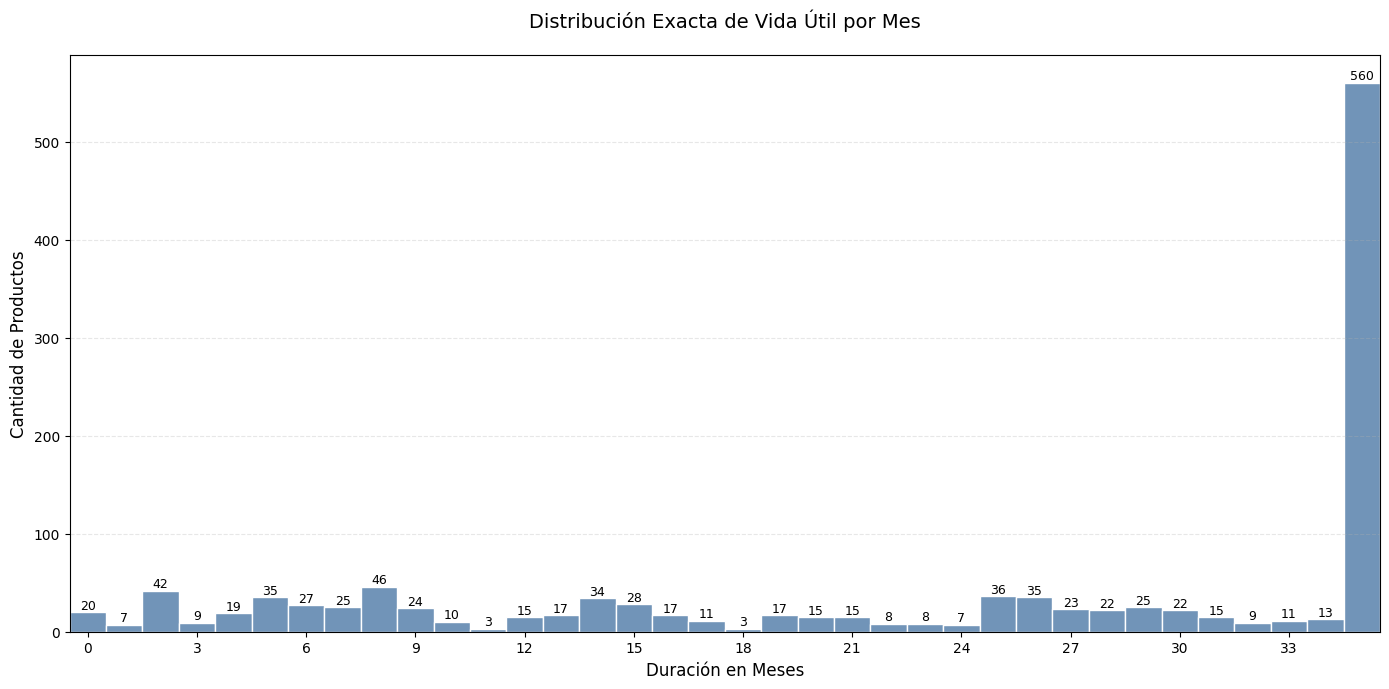

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Suponemos que ya tenés cargado tu DataFrame df con columnas: periodo (AAAAMM), customer_id, product_id, tn
# Convertimos periodo a datetime
df["periodo_dt"] = pd.to_datetime(df["periodo"].astype(str), format="%Y%m")

# Paso 2: Determinar periodo de vida útil de cada producto
vida_producto = df.groupby("product_id")["periodo_dt"].agg(["min", "max"]).reset_index()


# Función para calcular meses exactos
def meses_entre_fechas(f1, f2):
    return (f2.year - f1.year) * 12 + (f2.month - f1.month)

# Calcular duración en meses exactos
vida_producto['duracion_meses'] = vida_producto.apply(
    lambda x: meses_entre_fechas(x['min'], x['max']), 
    axis=1
)


# Calcular duración máxima en meses (asegurando cubrir todo el rango)
max_meses = vida_producto['duracion_meses'].max()
bins = int(max_meses) + 1  # +1 para incluir el último mes

# Crear el gráfico con bins exactos por mes
plt.figure(figsize=(14, 7))
ax = sns.histplot(
    data=vida_producto,
    x='duracion_meses',
    bins=bins,  # ¡Ajuste clave aquí!
    discrete=True,  # Para que cada barra sea un mes entero
    color='#4e79a7',
    edgecolor='white',
    alpha=0.8
)

# Añadir etiquetas a las barras
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f'{int(height)}',
            (p.get_x() + p.get_width() / 2., height),
            ha='center', va='center',
            xytext=(0, 5),
            textcoords='offset points',
            fontsize=9
        )

# Personalización avanzada
plt.title('Distribución Exacta de Vida Útil por Mes', pad=20, fontsize=14)
plt.xlabel('Duración en Meses', fontsize=12)
plt.ylabel('Cantidad de Productos', fontsize=12)
plt.xticks(np.arange(0, max_meses + 1, step=3))  # Muestra cada 3 meses
plt.grid(axis='y', linestyle='--', alpha=0.3)

# Ajustar ejes
ax.set_xlim(-0.5, max_meses + 0.5)  # Margen para visualización

plt.tight_layout()
plt.show()

In [155]:
vida_producto[vida_producto['max']>='2019-10-01'].shape

(959, 4)

# ¿Cuales son los 750 productos a predecir?

In [ ]:
# Suponiendo que tienes una columna de fecha (ej: 'periodo_dt')
fecha_maxima = df['periodo_dt'].max()
fecha_corte = fecha_maxima - pd.DateOffset(months=3)  # Resta exactamente 3 meses
# Agrupar por producto y encontrar su primera fecha de venta
primeras_ventas = df.groupby('product_id')['periodo_dt'].min().reset_index()
primeras_ventas.rename(columns={'periodo_dt': 'primera_fecha_venta'}, inplace=True)

# Filtrar productos cuya primera venta es >= fecha_corte
productos_nuevos = primeras_ventas[primeras_ventas['primera_fecha_venta'] >= fecha_corte]
df_productos_nuevos = df[df['product_id'].isin(productos_nuevos['product_id'])]

print(f"📅 Fecha de corte (hace 3 meses): {fecha_corte}")
print(f"🔍 Productos nuevos encontrados: {len(productos_nuevos)}")
print("📝 Ejemplo de productos nuevos:")
print(productos_nuevos.head())

In [68]:
mask = (df['tn']>0) & (df['periodo'] == 201912)
df[mask][['product_id']].nunique()

product_id    927
dtype: int64

# Clientes chicos

In [73]:
dfc = df.groupby(['customer_id'])['tn'].sum().reset_index().sort_values(by='tn', ascending=False)
dfc.tail(1)


,customer_id,tn
596,10637,0.00288


In [72]:
compras = df[df['customer_id']==10611].groupby(['periodo','customer_id'])['tn'].sum().reset_index().sort_values(by='tn', ascending=False)
compras

,periodo,customer_id,tn
0,201701,10611,0.72393
1,201705,10611,0.66474
2,201706,10611,0.54832
4,201710,10611,0.19047
5,201711,10611,0.07688
3,201707,10611,0.04586


# Excel

In [35]:
import pandas as pd

# Seleccionar columnas deseadas
columnas = ['cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'product_id']
df_export = productos[columnas].drop_duplicates().sort_values(by=columnas)

# Reemplazar valores repetidos por cadena vacía (""), para simular jerarquía
df_export[['cat1', 'cat2', 'cat3']] = df_export[['cat1', 'cat2', 'cat3']].mask(
    df_export[['cat1', 'cat2', 'cat3']].eq(df_export[['cat1', 'cat2', 'cat3']].shift())
)

# Exportar a Excel
df_export.to_excel("productos_jerarquico.xlsx", index=False)


In [45]:

# Seleccionar columnas deseadas y eliminar duplicados
df_simple = df[['cat1', 'cat2', 'cat3', 'brand', 'sku_size', 'product_id']].drop_duplicates()

# Exportar a Excel
df_simple.to_excel("catalogo_productos_simple.xlsx", index=False)
